# Behavioral Cloning


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2

import ntpath
import random

from imgaug import augmenters as ima

## Test Data from the Self-driving Car Simulator

This shows the directory structure and contents for this project.

In [2]:
!ls

CarND.yml      README.md      drive.py       model.ipynb
Models         Simulator      drive_sdcar.py output_images
README copy.md data           images         video.py


The `Data` directory contains the data generated by the simulator during training. I trained it in multiple runs. E.g., the data from one run is stored in `Driving Dataset 01`, while the data from a second run is stored in `Driving Dataset 02`. This notebook uses the second set of data I captured.

In [3]:
!ls "data/"

bridge_dataset    driving_dataset_X new copy
combined          new               recovery_dataset


It captures images as `JPG` files from each of the three cameras, and stores them in the `Data/IMG` directory. The file `driving_log.csv` contains a summary of the data. We will explore its contents a little further down. 

In [4]:
!ls "data/new/IMG" | wc -l

   57435


There are over 40,000 images in the test data set. These were genereated from performing 4 laps of the driving circuit, in each direction for a total of 8 laps. The reason I drove the car in both directions is to get a better dataset. Driving in one direction would result in most of the turns being left turns or right turns, depending on the direction of driving. Driving the same number of times around the track in both directions gives a more even distribution of data, which I verify below.

Let's look at the first few images from the left camera, the center camera, and the right camera.

In [5]:
!ls "data/new/IMG/" | grep 'left*' | head -3
!ls "data/new/IMG/" | grep 'center*' | head -3
!ls "data/new/IMG/" | grep 'right*' | head -3

left_2021_07_02_16_12_36_240.jpg
left_2021_07_02_16_12_36_308.jpg
left_2021_07_02_16_12_36_376.jpg
center_2021_07_02_16_12_36_240.jpg
center_2021_07_02_16_12_36_308.jpg
center_2021_07_02_16_12_36_376.jpg
right_2021_07_02_16_12_36_240.jpg
right_2021_07_02_16_12_36_308.jpg
right_2021_07_02_16_12_36_376.jpg


In [8]:
datadir_main = 'data/new'
datafile = 'driving_log.csv'

columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
pd.set_option('display.max_colwidth', None)

datafile_main = os.path.join(datadir_main, datafile)
data = pd.read_csv(datafile_main, names = columns)

In [9]:
data.head()

center  \
0  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_12_36_240.jpg   
1  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_12_36_308.jpg   
2  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_12_36_376.jpg   
3  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_12_36_444.jpg   
4  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_12_36_512.jpg   

                                                                                                                                                     left  \
0  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_12_36_240.jpg   
1  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_12_36_308.jpg   
2  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_12_36_376.jpg   
3  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_12_36_444.jpg   
4  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_12_36_512.jpg   

                                                                                                                                                     right  \
0  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_12_36_240.jpg   
1  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_12_36_308.jpg   
2  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_12_36_376.jpg   
3  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_12_36_444.jpg   
4  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_12_36_512.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0      0.0  0.000003  
1       0.0       0.0      0.0  0.000012  
2       0.0       0.0      0.0  0.000017  
3       0.0       0.0      0.0  0.000003  
4       0.0       0.0      0.0  0.000017

In [10]:
data.tail()

center  \
19140  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_44_54_180.jpg   
19141  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_44_54_251.jpg   
19142  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_44_54_318.jpg   
19143  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_44_54_389.jpg   
19144  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/center_2021_07_02_16_44_54_473.jpg   

                                                                                                                                                         left  \
19140  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_44_54_180.jpg   
19141  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_44_54_251.jpg   
19142  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_44_54_318.jpg   
19143  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_44_54_389.jpg   
19144  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/left_2021_07_02_16_44_54_473.jpg   

                                                                                                                                                         right  \
19140  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_44_54_180.jpg   
19141  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_44_54_251.jpg   
19142  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_44_54_318.jpg   
19143  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_44_54_389.jpg   
19144  /Users/kenpower/Development/GitHub Projects/SelfDrivingCarND_Projects/SelfDrivingCarND-BehavioralCloning/data/new/IMG/right_2021_07_02_16_44_54_473.jpg   

       steering  throttle  reverse     speed  
19140       0.0       0.0      0.0  4.977977  
19141       0.0       0.0      0.0  4.937973  
19142       0.0       0.0      0.0  4.908181  
19143       0.0       0.0      0.0  4.868737  
19144       0.0       0.0      0.0  4.839233

Merge the data from all the datasets into a single dataframe:

Shuffle the rows of the combined datasets:

In [11]:
#data = data.sample(frac=1)

Remove the path from the filename entries of the images, leaving just the filename.

In [12]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left']   = data['left'].apply(path_leaf)
data['right']  = data['right'].apply(path_leaf)


### Steering angle data
We will be using the steering angle data to train the network to steer the car. 

Plot the steering angles on a distribution, to see which angles are most frequent.

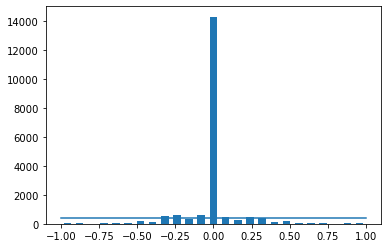

In [13]:
num_bins = 25
max_samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), 
          np.max(data['steering'])), 
         (max_samples_per_bin, max_samples_per_bin))

As might be expected, this shows that the angle of `0.0`, representing straight ahead, is the most common steering angle. However, for the purposes of training our neural network, this presents a problem because the center value dominate all other values, which would introduce bias in training our network.

The solution is to remove a set of the data from the center of the dataset, which results in a more normalized distribution of the data.

In [14]:
print('total data', len(data))
remove_list = []

for j in range(num_bins):
    list_ = []
    
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
            
    list_ = shuffle(list_)
    list_ = list_[max_samples_per_bin:]
    remove_list.extend(list_)
    
print('removed:', len(remove_list))

data.drop(data.index[remove_list], inplace=True)

print('remaining:', len(data))

total data 19145
removed: 14554
remaining: 4591


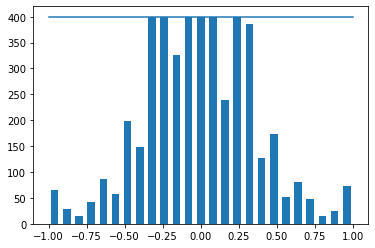

In [15]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), 
          np.max(data['steering'])), 
         (max_samples_per_bin, max_samples_per_bin))             

## Training and Validation Split

In [16]:
print(data.iloc[1])
def load_image_steering(datadir_main, df):
    image_path = []
    steering = []
    
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        image_path.append(os.path.join(datadir_main, center.strip()))
        steering.append(float(indexed_data[3]))
        
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    
    return image_paths, steerings

image_paths, steerings = load_image_steering(datadir_main + '/IMG', data)

center      center_2021_07_02_16_12_37_753.jpg
left          left_2021_07_02_16_12_37_753.jpg
right        right_2021_07_02_16_12_37_753.jpg
steering                                 -0.15
throttle                                   0.0
reverse                                    0.0
speed                                 0.401756
Name: 22, dtype: object


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, 
                                                      steerings, 
                                                      test_size=0.2, 
                                                      random_state=9)

print('Training samples: {}'.format(len(X_train)))
print('Validation samples: {}'.format(len(X_valid)))

Training samples: 3672
Validation samples: 919


Text(0.5, 1.0, 'Validation set')

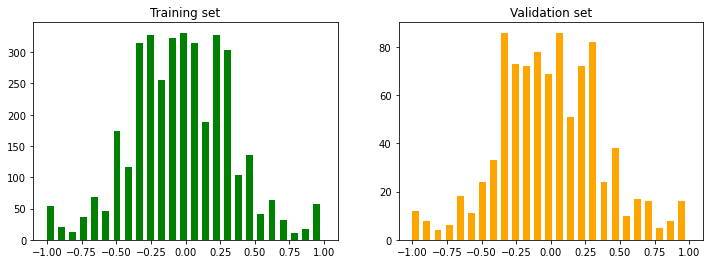

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='green')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='orange')
axes[1].set_title('Validation set')

## Generate additional data using augmentation techniques

As discussed in chapter 2 of the Dissertation document, applying augmentation techniques is a useful way to create more data from our existing data. This section of the notebook shows how I use zooming, panning, brightness, and flipping to create additional data for training the network. I then randomly apply multiple augmentations to the orginal data, so that, for example, one input image could result in an output image that is a variation that is flipped, rotated, and made brighter.

### Utility Functions

In [19]:
def plot_two_images(image1, image2, title1="Image 1", title2="Image 2"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()

    axes[0].imshow(image1)
    axes[0].set_title(title1)

    axes[1].imshow(image2)
    axes[1].set_title(title2)

### Zooming

In [20]:
def zoom(image):
    zoom = ima.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

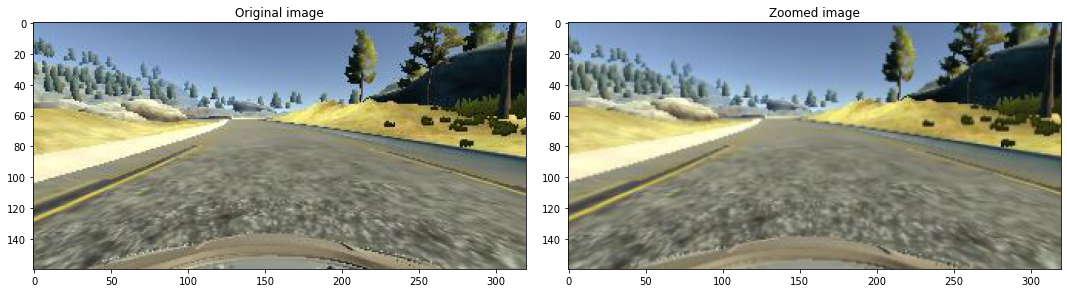

In [21]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

plot_two_images(original_image, zoomed_image, "Original image", "Zoomed image")

### Image panning

In [22]:
def pan(image):
    pan = ima.Affine(translate_percent={"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

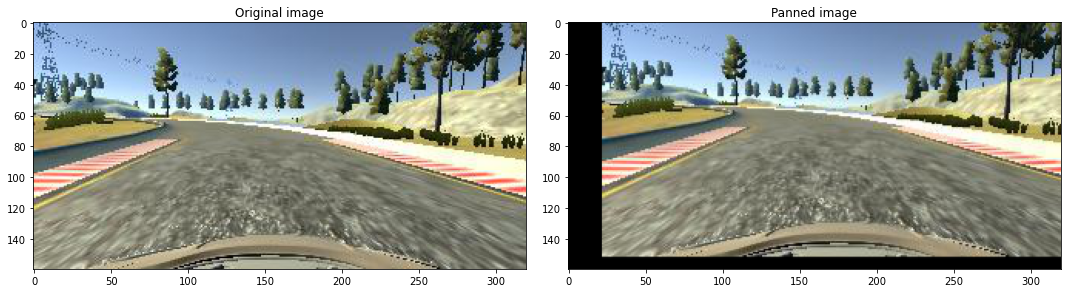

In [23]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

plot_two_images(original_image, panned_image, "Original image", "Panned image")

### Image brightness

In [24]:
def randomly_alter_brightness(image):
    brightness = ima.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

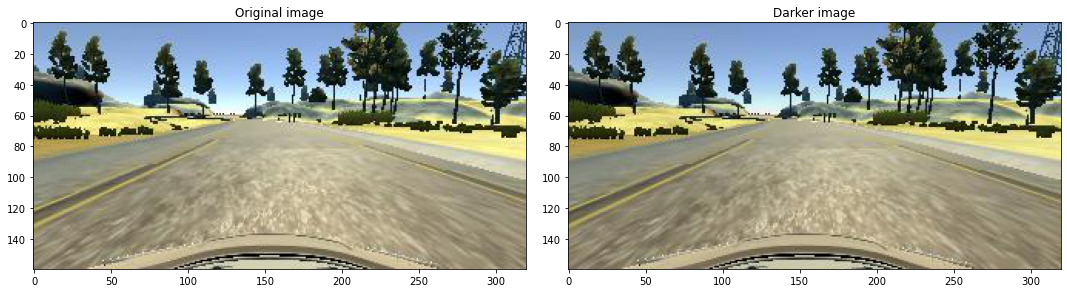

In [25]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
darker_image = randomly_alter_brightness(original_image)

plot_two_images(original_image, darker_image, "Original image", "Darker image")

### Flipping

In [26]:
def flip(image, steering_angle):
    HORIZONTAL_FLIP = 1
    image = cv2.flip(image, HORIZONTAL_FLIP)
    steering_angle = -steering_angle
    return image, steering_angle

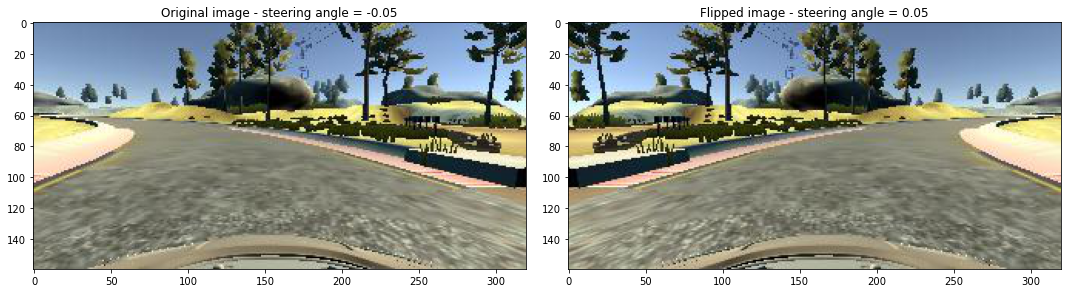

In [27]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = flip(original_image, steering_angle)

plot_two_images(
    original_image, 
    flipped_image, 
    "Original image - steering angle = {}".format(steering_angle), 
    "Flipped image - steering angle = {}".format(flipped_steering_angle)
)

### Randomly apply the augmentations
Note it may look like more than one transformation is being applied to a given original image, e.g., the augmented image may be flipped and darkened.

In [28]:
def random_augment(image, steering_angle):
    augmentation_types = []
    
    # we don't want any one transform used more than 50% of the time
    FREQUENCY_THRESHOLD = 0.5 
    
    image = mpimg.imread(image)
    
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image = pan(image)
        augmentation_types.append("Pan")
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image = zoom(image)
        augmentation_types.append("Zoom")
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image = randomly_alter_brightness(image)
        augmentation_types.append("Brightness")
    if np.random.rand() < FREQUENCY_THRESHOLD:
        image, steering_angle = flip(image, steering_angle)
        augmentation_types.append("Flip")

    return image, steering_angle, augmentation_types

In [29]:
def plot_ten_random_augmented_images():
    columns = 2
    rows = 10

    fig, axs = plt.subplots(rows, columns, figsize=(15, 50))
    fig.tight_layout()

    for i in range(10):
        random_index = random.randint(0, len(image_paths) - 1)
        random_image = image_paths[random_index]
        random_steering_angle = steerings[random_index]

        original_image = mpimg.imread(random_image)
        augmented_image, augmented_steering_angle, augmentation_type = \
            random_augment(random_image, random_steering_angle)

        axs[i][0].imshow(original_image)
        axs[i][0].set_title("Original image - steering angle = {}"\
                            .format(random_steering_angle))
        axs[i][1].imshow(augmented_image)
        axs[i][1].set_title("Augmented image ({}) - steering angle = {}"\
                            .format(augmentation_type ,augmented_steering_angle))

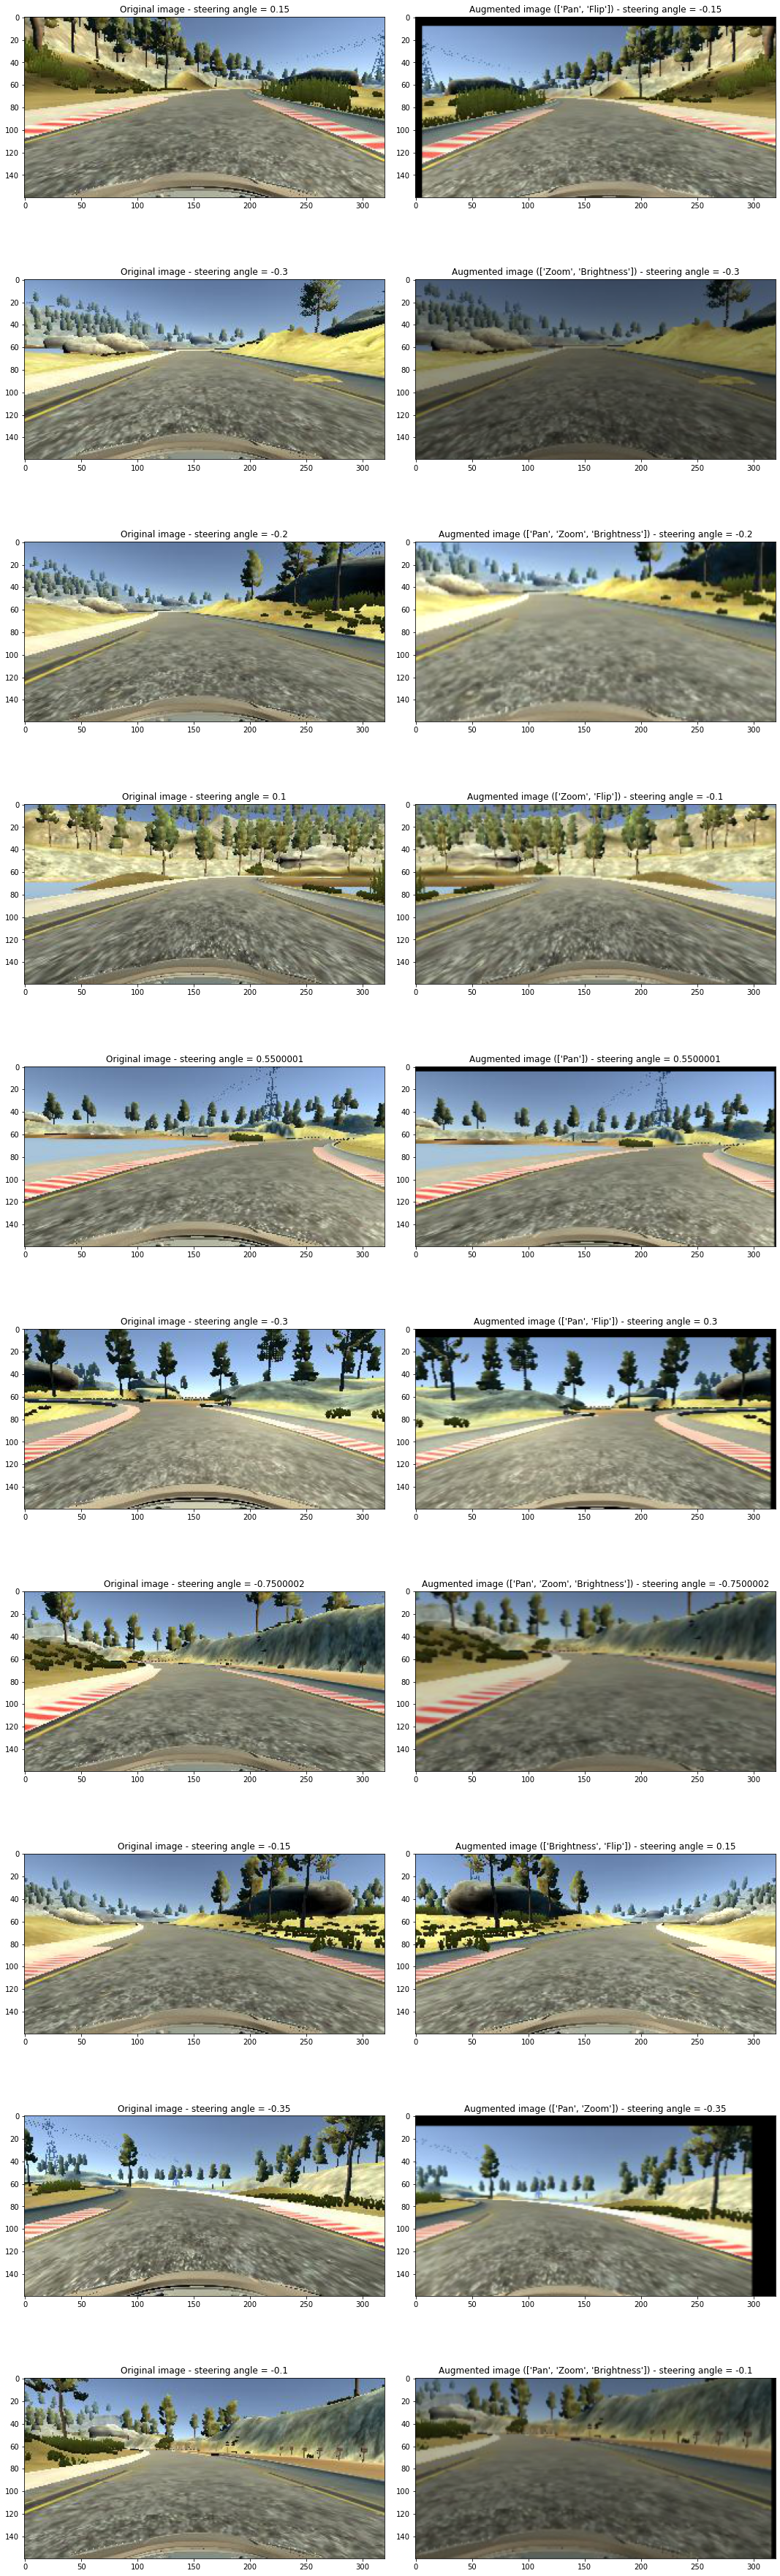

In [30]:
plot_ten_random_augmented_images()

## Preprocessing our data

In [31]:
top_of_image = 60
bottom_of_image = 135

def image_preprocess(image):
    image = image[top_of_image:bottom_of_image, :, :]
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    
    kernel_size = (3,3)
    image = cv2.GaussianBlur(image, kernel_size, 0)
    
    target_size = (200, 66) # per NVidia model recommendations
    image = cv2.resize(image, target_size)
    
    # normalize the image
    image = image/255
    
    return image

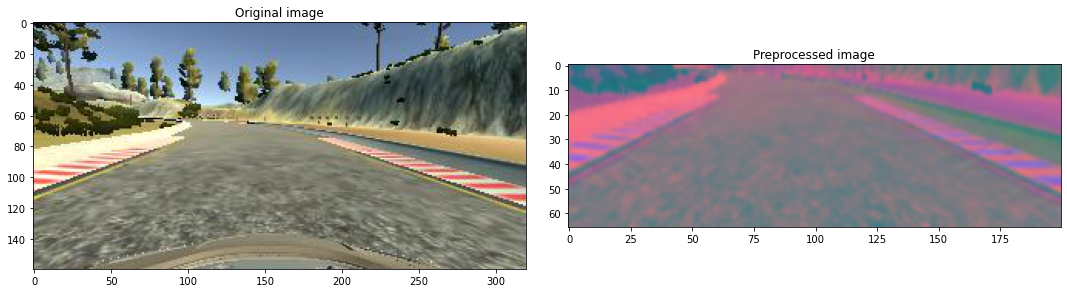

In [32]:
# select a random image to visualize
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = image_preprocess(original_image)

plot_two_images(original_image, 
                preprocessed_image, 
                "Original image", 
                "Preprocessed image")

### Batch Image Generator
The Batch Generator allows us to generate augmented images on the fly, when needed. 

In [33]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
        
        while True:
            batch_img = []
            batch_steering = []
            
            for i in range(batch_size):
                random_index = random.randint(0, len(image_paths) - 1)
                
                if is_training:
                    im, steering, aug_type = \
                        random_augment(image_paths[random_index], 
                                        steering_angles[random_index])
                else:
                    im = mpimg.imread(image_paths[random_index])
                    steering = steering_angles[random_index]
                    
                im = image_preprocess(im)
                batch_img.append(im)
                batch_steering.append(steering)
                
            yield (np.asarray(batch_img), np.asarray(batch_steering))

Plot images to verify our generator is working as expected.

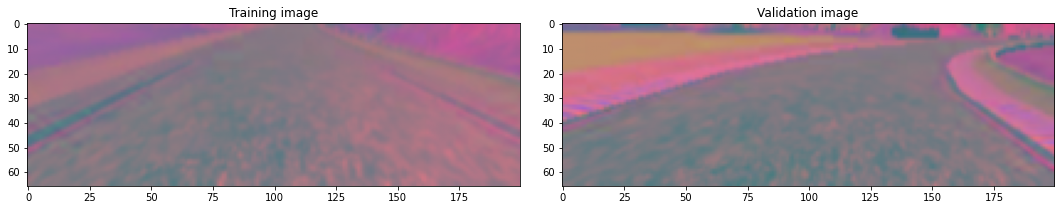

In [34]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

plot_two_images(x_train_gen[0], 
                x_valid_gen[0], 
                'Training image', 
                'Validation image')

## Defining NVidia Model Architecture for Behavioural Cloning
A popular model used for behavioural cloning is the one proposed by NVidia. It is also implemented in real-life self-driving cars.

We are going to implement this architecture from the paper by [Bojarski, et al. 2016](#References).

![CNN Architecture](./images/CNN_architecture.PNG)


We can see from the diagram that the Nvidia model begins with an Input layer (the Input planes at the bottom of the diagram), and then has a Normalization layer. We are going to skip the Normalization layer in our implementation because we have already normalized the data outside of our model, as part of the image processing. The normalized data is then passed into a convolutional layer.

Note, we can prevent overfitting by using a dropout layer in the model. Note, I experimented with Dropout Layers in different positions in the model at different times, and with varying dropout rates. Eventually, by experimenting with the hyperparameter values during training, I was able to reduce overfitting without the use of dropout layers.
    

In [35]:
def nvidia_model():
    model = Sequential(name="Vehicle_Control")
    
    stride_size = (2,2)
    
    image_height = 66
    image_width = 200
    number_of_channels = 3
    dropout_rate = 0.5
    learning_rate = 1e-4
    
    input_dimensions = (image_height, image_width, number_of_channels)
    
    model.add(Conv2D(24, (5, 5), stride_size, 
                            input_shape=input_dimensions, 
                            activation='elu', name='Convolutional_feature_map_24_31x98'))
    
    model.add(Conv2D(36, (5, 5), stride_size, activation='elu', name='Convolutional_feature_map_36_14x47'))
    model.add(Conv2D(48, (5, 5), stride_size, activation='elu', name='Convolutional_feature_map_48_5x22'))
    model.add(Conv2D(64, (3, 3), activation='elu', name='Convolutional_feature_map_64_3x20'))    
    model.add(Conv2D(64, (3, 3), activation='elu', name='Convolutional_feature_map_64_1x18'))    
    #model.add(Dropout(dropout_rate))

    model.add(Flatten(name='Flatten'))
    
    model.add(Dense(100, activation='elu', name='Fully_connected_100'))
    #model.add(Dropout(dropout_rate))

    model.add(Dense(50, activation='elu', name='Fully_connected_50'))
    #model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation='elu', name='Fully_connected_10'))    
    #model.add(Dropout(dropout_rate))
    
    # outputs the predicted steering angle for our self-driving car
    model.add(Dense(1, name='Output_vehicle_control')) 
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mae'])
    
    return model

In [36]:
vehicle_control_model = nvidia_model()

print(vehicle_control_model.summary())

Model: "Vehicle_Control"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolutional_feature_map_24 (None, 31, 98, 24)        1824      
_________________________________________________________________
Convolutional_feature_map_36 (None, 14, 47, 36)        21636     
_________________________________________________________________
Convolutional_feature_map_48 (None, 5, 22, 48)         43248     
_________________________________________________________________
Convolutional_feature_map_64 (None, 3, 20, 64)         27712     
_________________________________________________________________
Convolutional_feature_map_64 (None, 1, 18, 64)         36928     
_________________________________________________________________
Flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
Fully_connected_100 (Dense)  (None, 100)           

## Training the model


In [37]:
batch_size = 100

training_generator = batch_generator(X_train, y_train, batch_size, True)
validation_generator = batch_generator(X_valid, y_valid, batch_size, False)

steps_per_epoch = 300 # len(X_train)//batch_size
validation_steps = 200 # len(X_valid)//batch_size 

epochs = 10

In [38]:
print(steps_per_epoch)
print(validation_steps)

300
200


In [39]:
history = vehicle_control_model.fit(training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=epochs,
                                    validation_data=validation_generator,
                                    validation_steps=validation_steps,
                                    verbose=1,
                                    shuffle=1)

Epoch 1/10
300/300 [==============================] - 126s 388ms/step - loss: 0.1160 - accuracy: 0.0892 - mae: 0.2600 - val_loss: 0.0549 - val_accuracy: 0.0888 - val_mae: 0.1816
Epoch 2/10
300/300 [==============================] - 114s 382ms/step - loss: 0.0795 - accuracy: 0.0918 - mae: 0.2138 - val_loss: 0.0497 - val_accuracy: 0.0866 - val_mae: 0.1726
Epoch 3/10
300/300 [==============================] - 111s 372ms/step - loss: 0.0707 - accuracy: 0.0922 - mae: 0.2031 - val_loss: 0.0492 - val_accuracy: 0.0865 - val_mae: 0.1720
Epoch 4/10
300/300 [==============================] - 112s 374ms/step - loss: 0.0655 - accuracy: 0.0921 - mae: 0.1957 - val_loss: 0.0485 - val_accuracy: 0.0808 - val_mae: 0.1718
Epoch 5/10
300/300 [==============================] - 111s 372ms/step - loss: 0.0604 - accuracy: 0.0949 - mae: 0.1894 - val_loss: 0.0461 - val_accuracy: 0.0822 - val_mae: 0.1669
Epoch 6/10
300/300 [==============================] - 114s 382ms/step - loss: 0.0597 - accuracy: 0.0897 - mae:

### Visualize the metrics

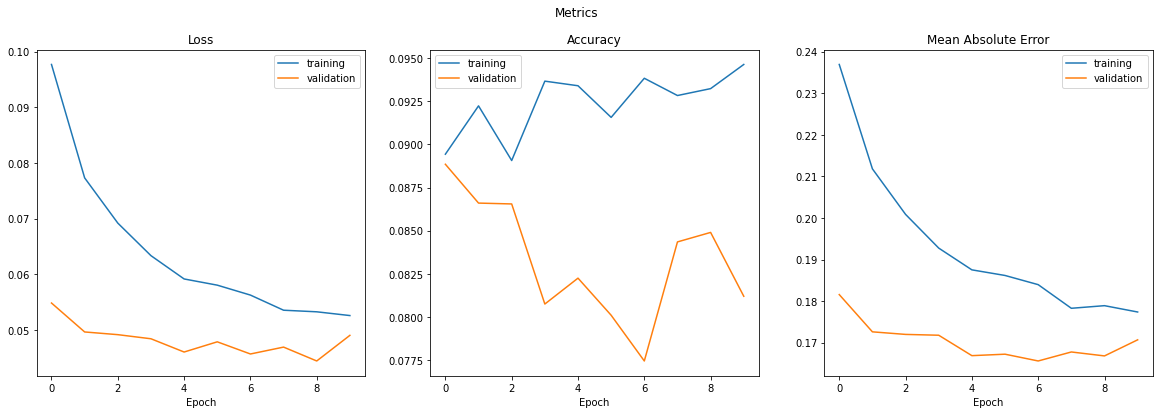

In [40]:
plt.figure(figsize=(20,6))
plt.suptitle("Metrics")


plt.subplot(131)
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(132)
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')


plt.subplot(133)
plt.title('Mean Absolute Error')
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['training', 'validation'])
plt.xlabel('Epoch')

plt.show()

At this point, let's save the model, and verify it is saved to the specified location.

In [41]:
models_dir = 'Models'
model_name = 'model.h5'

vehicle_control_model.save(models_dir + '/' + model_name)

In [42]:
!ls $models_dir

model.h5


This is the model I will use in the simulated vehicle. The self-driving car will use this model to control the steering.

# References
* Bojarski, M., Del Testa, D., Dworakowski, D., Firner, B., Flepp, B., Goyal, P., Jackel, L.D., Monfort, M., Muller, U., Zhang, J. and Zhang, X., 2016. [End to end learning for self-driving cars](https://arxiv.org/pdf/1604.07316.pdf). arXiv preprint arXiv:1604.07316.
